In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from collections import Counter
import pandas as pd
import pickle as pkl
import random
import pdb
from tqdm import tqdm_notebook


In [3]:
random.seed(186)

BATCH_SIZE = 256
MAX_SENTENCE_LENGTH = 1000
EMBED_SIZE = 300
# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1
PAD = '<pad>'
UNK = '<unk>'

label_to_id = {'contradiction' : 0, 'entailment' : 1, 'neutral' : 2}

def load_fasttext():
    fasttext_home = './'
    words_to_load = 50000

    loaded_embeddings = np.zeros((words_to_load + 2, EMBED_SIZE)) #+2 to account for pad and unk tokens
    words = {}
    idx2words = {}
    with open(fasttext_home + 'wiki-news-300d-1M.vec') as f:
        loaded_embeddings[PAD_IDX, :] = np.zeros((1, EMBED_SIZE))
        loaded_embeddings[UNK_IDX, :] = np.zeros((1, EMBED_SIZE))
        words[PAD] = PAD_IDX
        words[UNK] = UNK_IDX
        for i, line in enumerate(f):
            if i >= words_to_load: 
                break
            s = line.split()
            idx = i + 2 #+2 to account for PAD and UNK tokens
            loaded_embeddings[idx, :] = np.asarray(s[1:])
            words[s[0]] = idx 
            idx2words[idx] = s[0]
    return loaded_embeddings, words, idx2words

def load_snli_data():
    snli_train = pd.read_csv('./snli_train.tsv', names=['sentence1', 'sentence2', 'label'], skiprows=1, sep='\t|\n', engine='python')
    snli_val = pd.read_csv('./snli_val.tsv', names=['sentence1', 'sentence2', 'label'], skiprows=1, sep='\t|\n', engine='python')
    return snli_train[['sentence1', 'sentence2']], [label_to_id[x] for x in snli_train['label']], snli_val[['sentence1', 'sentence2']], [label_to_id[x] for x in snli_val['label']]


In [4]:
loaded_embeddings, words, idx2words = load_fasttext()

In [5]:
snli_train_sentences, snli_train_labels, snli_val_sentences, snli_val_labels = load_snli_data()
def map_sentence_to_idxs(sentence):
    return [words[tkn] if tkn in words else UNK_IDX for tkn in sentence]
snli_train_sentences_idxs = snli_train_sentences.applymap(lambda x: map_sentence_to_idxs(x))
snli_val_sentences_idxs = snli_val_sentences.applymap(lambda x: map_sentence_to_idxs(x))

In [6]:
class SNLIDataset(Dataset):    
    def __init__(self, data_list, target_list):
        """
        @param data_list: two sentence lists 
        @param target_list: list of targets 

        """
        self.x1 = data_list['sentence1']
        self.x2 = data_list['sentence2']
        self.y = target_list
        assert (len(self.x1) == len(self.x2) == len(self.y))

    def __len__(self):
        return len(self.y)
        
    def __getitem__(self, key):        
        sent1_idx = self.x1[key][:MAX_SENTENCE_LENGTH]
        sent2_idx = self.x2[key][:MAX_SENTENCE_LENGTH]
        label = self.y[key]
        return [sent1_idx, sent2_idx, len(sent1_idx), len(sent2_idx), label]

def SNLI_collate_function(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    sentence1_list = []
    sentence2_list = []
    label_list = []
    length_list_1 = []
    length_list_2 = []
    # padding
    for datum in batch:
        length_list_1.append(datum[2])
        length_list_2.append(datum[3])
        label_list.append(datum[4])
        padded_vec_1 = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[2])), 
                                mode="constant", constant_values=0)
        sentence1_list.append(padded_vec_1)
        padded_vec_2 = np.pad(np.array(datum[1]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[3])), 
                                mode="constant", constant_values=0)
        sentence2_list.append(padded_vec_2)
    return [torch.from_numpy(np.array(sentence1_list)), torch.from_numpy(np.array(sentence2_list)), 
            torch.cuda.LongTensor(label_list)]


In [7]:
snli_train_dataset = SNLIDataset(snli_train_sentences_idxs, snli_train_labels)
snli_train_loader = torch.utils.data.DataLoader(dataset=snli_train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=SNLI_collate_function,
                                           shuffle=True)
snli_val_dataset = SNLIDataset(snli_val_sentences_idxs, snli_val_labels)
snli_val_loader = torch.utils.data.DataLoader(dataset=snli_val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=SNLI_collate_function,
                                           shuffle=True)


In [8]:
class BidirectionalGRU(nn.Module):
    def __init__(self, hidden_size, num_layers):
        # BidirectionalGRU Accepts the following hyperparams:
        # hidden_size: Hidden Size of layer in the GRU
        # num_layers: number of layers in the GRU
        super(BidirectionalGRU, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(loaded_embeddings), freeze=False)
        self.gru = nn.GRU(EMBED_SIZE, hidden_size, num_layers, batch_first=True, bidirectional=True)

    def init_hidden(self, batch_size):
        hidden = torch.randn(self.num_layers*2, batch_size, self.hidden_size)
        return hidden

    def forward(self, x):
        batch_size, seq_len = x.size()
        self.hidden = self.init_hidden(batch_size)
        lengths = (x.data != 0).sum(dim=1).cuda()
        _, idx_sort = torch.sort(lengths, dim=0, descending=True) # sort in descending order of number of words
        _, idx_unsort = torch.sort(idx_sort, dim=0)
        lengths = list(lengths[idx_sort])
        idx_sort = torch.autograd.Variable(idx_sort).cuda()
        idx_unsort = torch.autograd.Variable(idx_unsort).cuda()
        
        x = x.index_select(0, idx_sort)

        embed = self.embedding(x)
        #update embedding if token is unk
        m = (x == 1).type(torch.cuda.FloatTensor)
        m = m.unsqueeze(2).repeat(1, 1, EMBED_SIZE)
        embed = m * embed + (1-m) * embed.clone().detach()
        embed = torch.nn.utils.rnn.pack_padded_sequence(embed.cuda(), lengths, batch_first=True)
        _, hidden = self.gru(embed.cuda(), self.hidden.cuda())
        hidden = hidden[0, :, :] + hidden[1, :, :]
        return hidden.index_select(0, idx_unsort)


In [66]:
def test_gru_model(loader, gru_model, fully_connected):
    correct = 0
    total = 0
    gru_model.eval()
    for sent1_batch, sent2_batch, labels_batch in loader:
        hidden_1 = gru_model(sent1_batch.cuda())
        hidden_2 = gru_model(sent2_batch.cuda())
        encoded_output = torch.cat([hidden_1, hidden_2], dim=1).cuda()
        outputs = []
        for output in encoded_output:
            outputs.append(fully_connected(output.cuda()))
        outputs = torch.stack(outputs).cuda()
        predicted = F.softmax(outputs)
        predicted = outputs.max(1, keepdim=True)[1]
        total += labels_batch.size(0)
        correct += predicted.eq(labels_batch.view_as(predicted)).sum().item()
    return (100 * correct / total)

def train_gru_model(hidden_size):
    torch.cuda.empty_cache()
    gru_model = BidirectionalGRU(hidden_size=hidden_size, num_layers=1)
    gru_model = gru_model.cuda()

    num_epochs = 15 # number epoch to train
    criterion = torch.nn.CrossEntropyLoss()
    learning_rate = 3e-4
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, gru_model.parameters()), lr=learning_rate)
    fully_connected = nn.Sequential(nn.Linear(hidden_size*2, hidden_size), nn.ReLU(inplace=True), nn.Linear(hidden_size, 3)).cuda()

    train_accs = {}
    val_accs = {}
    losses = {}
    for epoch in range(num_epochs):
        for i, (sent1, sent2, labels) in enumerate(snli_train_loader):
            gru_model.train()
            optimizer.zero_grad()
            # Forward pass
            hidden_1 = gru_model(sent1.cuda())
            hidden_2 = gru_model(sent2.cuda())
            encoded_output = torch.cat([hidden_1, hidden_2], dim=1).cuda()
            outputs = []
            for output in encoded_output:
                outputs.append(fully_connected(output.cuda()))
            outputs = torch.stack(outputs).cuda()
            loss = criterion(outputs, labels.cuda())
            loss.backward()
            optimizer.step()
        val_acc = test_gru_model(snli_val_loader, gru_model, fully_connected)
        train_acc = test_gru_model(snli_train_loader, gru_model, fully_connected)
        train_accs[epoch + 1] = train_acc
        val_accs[epoch + 1] = val_acc
        losses[epoch + 1] = loss
        print('Epoch: [{}/{}], Training Acc: {}, Validation Acc: {}'.format(
                   epoch+1, num_epochs, train_acc, val_acc))
                
    return gru_model, train_accs, val_accs, losses

In [89]:
class CNN(nn.Module):
    def __init__(self, hidden_size, num_layers, kernel_size):

        super(CNN, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(loaded_embeddings), freeze=False)
    
        self.conv1 = nn.Conv1d(EMBED_SIZE, hidden_size, kernel_size=kernel_size, padding=2)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=kernel_size, padding=2)

        self.maxpool = nn.MaxPool1d(kernel_size=kernel_size, padding=2)

    def forward(self, x):
        batch_size, seq_len = x.size()

        embed = self.embedding(x)
        hidden = self.conv1(embed.transpose(1,2)).transpose(1,2)
        hidden = F.relu(hidden.contiguous().view(-1, hidden.size(-1))).view(batch_size, seq_len, hidden.size(-1))

        hidden = self.conv2(hidden.transpose(1,2)).transpose(1,2)
        hidden = F.relu(hidden.contiguous().view(-1, hidden.size(-1))).view(batch_size, seq_len, hidden.size(-1))

        hidden = torch.sum(hidden, dim=1)
        return hidden


In [94]:
def test_cnn_model(loader, cnn_model, fully_connected):
    correct = 0
    total = 0
    cnn_model.eval()
    for sent1_batch, sent2_batch, labels_batch in loader:
        labels_batch = labels_batch.cuda()
        sent1_batch = sent1_batch.cuda()
        sent2_batch = sent2_batch.cuda()
        hidden_1 = cnn_model(sent1_batch)
        hidden_2 = cnn_model(sent2_batch)
        encoded_output = torch.cat([hidden_1, hidden_2], dim=1).cuda()
        outputs = []
        for output in encoded_output:
            outputs.append(fully_connected(output.cuda()))
        outputs = torch.stack(outputs).cuda()
        predicted = F.softmax(outputs).cuda()
        predicted = outputs.max(1, keepdim=True)[1].cuda()
        total += labels_batch.size(0)
        correct += predicted.eq(labels_batch.view_as(predicted)).sum().item()
    return (100 * correct / total)

def train_cnn_model(hidden_size, kernel_size):
    torch.cuda.empty_cache()
    cnn_model = CNN(hidden_size=hidden_size, num_layers=2, kernel_size = kernel_size)
    cnn_model.cuda()

    num_epochs = 15 # number epoch to train
    criterion = torch.nn.CrossEntropyLoss()
    learning_rate = 3e-4
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, cnn_model.parameters()), lr=learning_rate)
    fully_connected = nn.Sequential(nn.Linear(hidden_size*2, hidden_size), nn.ReLU(inplace=True), nn.Linear(hidden_size, 3)).cuda()

    train_accs = {}
    val_accs = {}
    losses = {}
    for epoch in range(num_epochs):
        for i, (sent1, sent2, labels) in enumerate(snli_train_loader):
            cnn_model.train()
            sent1 = sent1.cuda()
            sent2 = sent2.cuda()
            optimizer.zero_grad()
            # Forward pass
            hidden_1 = cnn_model(sent1.cuda())
            hidden_2 = cnn_model(sent2.cuda())
            encoded_output = torch.cat([hidden_1, hidden_2], dim=1).cuda()
            outputs = []
            for output in encoded_output:
                outputs.append(fully_connected(output.cuda()))
            outputs = torch.stack(outputs).cuda()
            loss = criterion(outputs, labels.cuda())
            loss.backward()
            optimizer.step()
        val_acc = test_cnn_model(snli_val_loader, cnn_model, fully_connected)
        train_acc = test_cnn_model(snli_train_loader, cnn_model, fully_connected)
        train_accs[epoch + 1] = train_acc
        val_accs[epoch + 1] = val_acc
        losses[epoch + 1] = loss
        print('Epoch: [{}/{}], Training Acc: {}, Validation Acc: {}'.format(
                   epoch+1, num_epochs, train_acc, val_acc))
                
    return cnn_model, train_accs, val_accs, losses

In [ ]:
gru_model, gru_train_accs, gru_val_accs, gru_losses = train_gru_model(200)

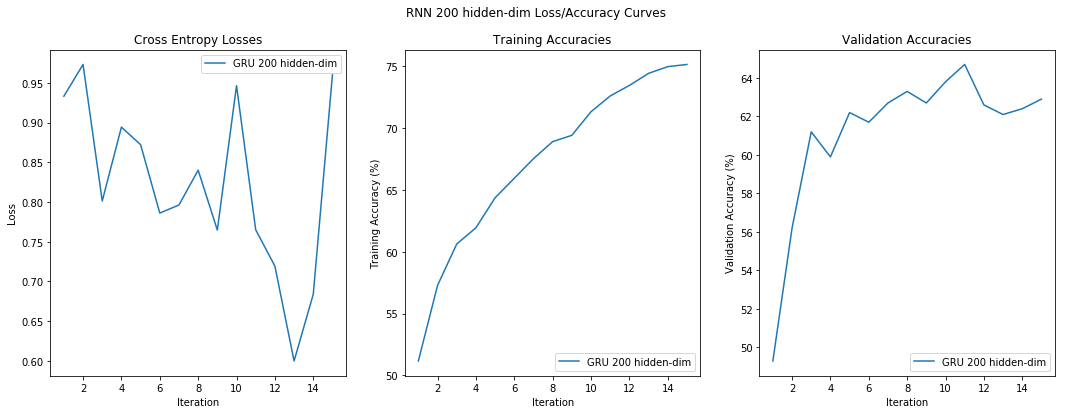

In [57]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=False)
axs[0].plot(*zip(*sorted(gru_losses.items())), label="GRU 200 hidden-dim")
axs[0].set_title('Cross Entropy Losses')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Loss')
axs[0].legend(loc="upper right")

axs[1].plot(*zip(*sorted(gru_train_accs.items())), label="GRU 200 hidden-dim")
axs[1].set_title('Training Accuracies')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Training Accuracy (%)')
axs[1].legend(loc="lower right")

axs[2].plot(*zip(*sorted(gru_val_accs.items())), label="GRU 200 hidden-dim")
axs[2].set_title('Validation Accuracies')
axs[2].set_xlabel('Iteration')
axs[2].set_ylabel('Validation Accuracy (%)')
axs[2].legend(loc="lower right")

fig.suptitle('RNN 200 hidden-dim Loss/Accuracy Curves')
plt.show()

In [ ]:
gru_model_2, gru_train_accs_2, gru_val_accs_2, gru_losses_2 = train_gru_model(100)

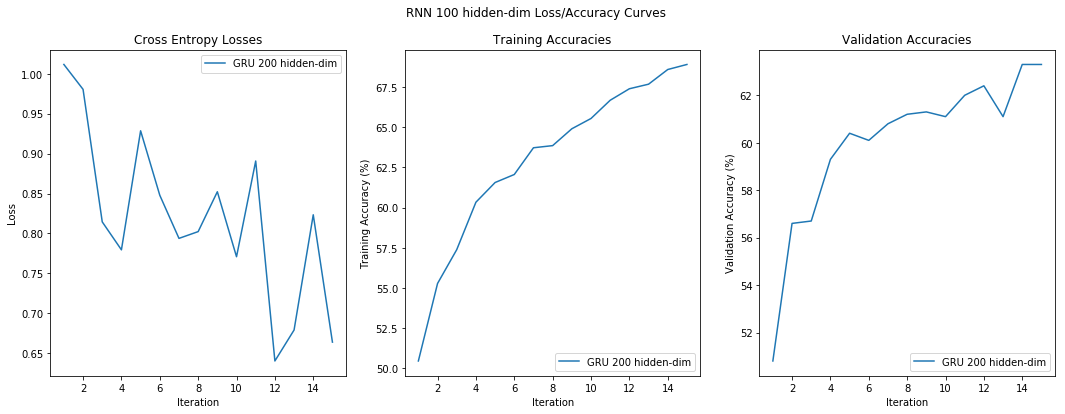

In [58]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=False)
axs[0].plot(*zip(*sorted(gru_losses_2.items())), label="GRU 200 hidden-dim")
axs[0].set_title('Cross Entropy Losses')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Loss')
axs[0].legend(loc="upper right")

axs[1].plot(*zip(*sorted(gru_train_accs_2.items())), label="GRU 200 hidden-dim")
axs[1].set_title('Training Accuracies')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Training Accuracy (%)')
axs[1].legend(loc="lower right")

axs[2].plot(*zip(*sorted(gru_val_accs_2.items())), label="GRU 200 hidden-dim")
axs[2].set_title('Validation Accuracies')
axs[2].set_xlabel('Iteration')
axs[2].set_ylabel('Validation Accuracy (%)')
axs[2].legend(loc="lower right")

fig.suptitle('RNN 100 hidden-dim Loss/Accuracy Curves')
plt.show()

In [ ]:
cnn_model, cnn_train_accs, cnn_val_accs, cnn_losses = train_cnn_model(200, 3)

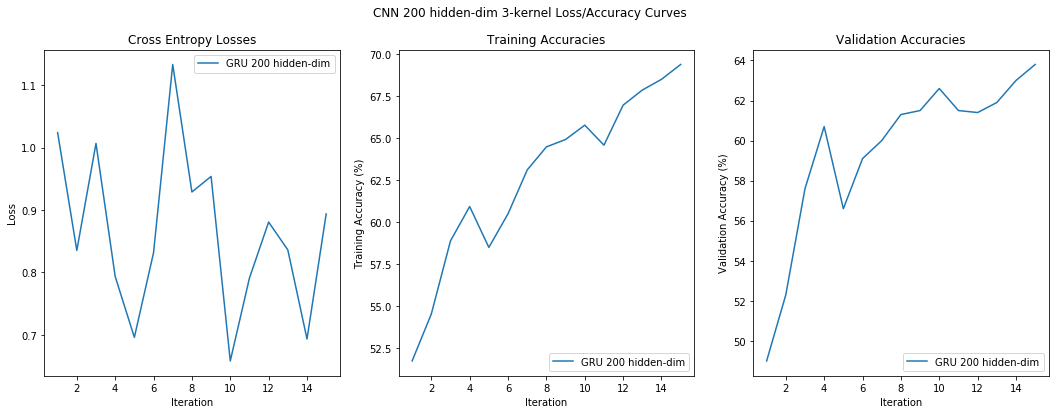

In [98]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=False)
axs[0].plot(*zip(*sorted(cnn_losses.items())), label="GRU 200 hidden-dim")
axs[0].set_title('Cross Entropy Losses')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Loss')
axs[0].legend(loc="upper right")

axs[1].plot(*zip(*sorted(cnn_train_accs.items())), label="GRU 200 hidden-dim")
axs[1].set_title('Training Accuracies')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Training Accuracy (%)')
axs[1].legend(loc="lower right")

axs[2].plot(*zip(*sorted(cnn_val_accs.items())), label="GRU 200 hidden-dim")
axs[2].set_title('Validation Accuracies')
axs[2].set_xlabel('Iteration')
axs[2].set_ylabel('Validation Accuracy (%)')
axs[2].legend(loc="lower right")

fig.suptitle('CNN 200 hidden-dim 3-kernel Loss/Accuracy Curves')
plt.show()

In [ ]:
cnn_model_2, cnn_train_accs_2, cnn_val_accs_2, cnn_losses_3 = train_cnn_model(100, 3)

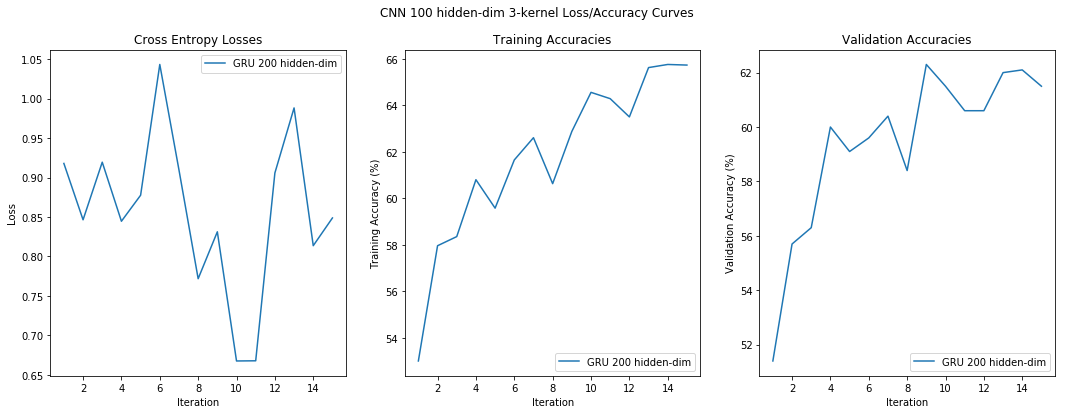

In [99]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=False)
axs[0].plot(*zip(*sorted(cnn_losses_2.items())), label="GRU 200 hidden-dim")
axs[0].set_title('Cross Entropy Losses')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Loss')
axs[0].legend(loc="upper right")

axs[1].plot(*zip(*sorted(cnn_train_accs_2.items())), label="GRU 200 hidden-dim")
axs[1].set_title('Training Accuracies')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Training Accuracy (%)')
axs[1].legend(loc="lower right")

axs[2].plot(*zip(*sorted(cnn_val_accs_2.items())), label="GRU 200 hidden-dim")
axs[2].set_title('Validation Accuracies')
axs[2].set_xlabel('Iteration')
axs[2].set_ylabel('Validation Accuracy (%)')
axs[2].legend(loc="lower right")

fig.suptitle('CNN 100 hidden-dim 3-kernel Loss/Accuracy Curves')
plt.show()

In [97]:
cnn_model_3, cnn_train_accs_3, cnn_val_accs_3, cnn_losses_3 = train_cnn_model(200, 5)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


Epoch: [1/15], Training Acc: 53.615, Validation Acc: 51.9
Epoch: [2/15], Training Acc: 58.875, Validation Acc: 57.2
Epoch: [3/15], Training Acc: 61.455, Validation Acc: 60.6
Epoch: [4/15], Training Acc: 63.219, Validation Acc: 62.5
Epoch: [5/15], Training Acc: 64.09, Validation Acc: 63.3
Epoch: [6/15], Training Acc: 64.98, Validation Acc: 62.2
Epoch: [7/15], Training Acc: 65.604, Validation Acc: 62.1
Epoch: [8/15], Training Acc: 66.051, Validation Acc: 62.8
Epoch: [9/15], Training Acc: 67.194, Validation Acc: 64.4
Epoch: [10/15], Training Acc: 67.298, Validation Acc: 62.4
Epoch: [11/15], Training Acc: 68.391, Validation Acc: 62.7
Epoch: [12/15], Training Acc: 68.687, Validation Acc: 63.4
Epoch: [13/15], Training Acc: 69.581, Validation Acc: 63.3
Epoch: [14/15], Training Acc: 69.514, Validation Acc: 64.4
Epoch: [15/15], Training Acc: 69.63, Validation Acc: 63.4


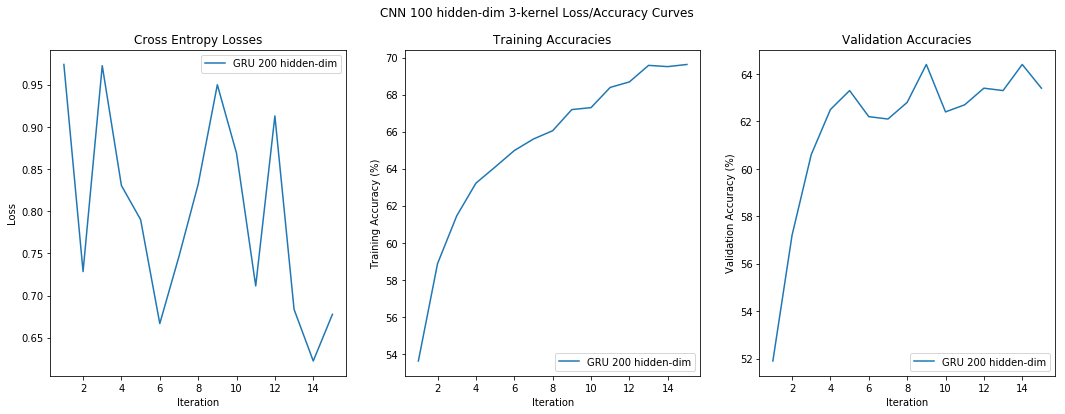

In [100]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=False)
axs[0].plot(*zip(*sorted(cnn_losses_3.items())), label="GRU 200 hidden-dim")
axs[0].set_title('Cross Entropy Losses')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Loss')
axs[0].legend(loc="upper right")

axs[1].plot(*zip(*sorted(cnn_train_accs_3.items())), label="GRU 200 hidden-dim")
axs[1].set_title('Training Accuracies')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Training Accuracy (%)')
axs[1].legend(loc="lower right")

axs[2].plot(*zip(*sorted(cnn_val_accs_3.items())), label="GRU 200 hidden-dim")
axs[2].set_title('Validation Accuracies')
axs[2].set_xlabel('Iteration')
axs[2].set_ylabel('Validation Accuracy (%)')
axs[2].legend(loc="lower right")

fig.suptitle('CNN 100 hidden-dim 3-kernel Loss/Accuracy Curves')
plt.show()

In [107]:
cnn_train_accs_3

{1: 53.615,
 2: 58.875,
 3: 61.455,
 4: 63.219,
 5: 64.09,
 6: 64.98,
 7: 65.604,
 8: 66.051,
 9: 67.194,
 10: 67.298,
 11: 68.391,
 12: 68.687,
 13: 69.581,
 14: 69.514,
 15: 69.63}

## MNLI

In [129]:
def load_mnli_data():
    mnli_train = pd.read_csv('./mnli_train.tsv', names=['sentence1', 'sentence2', 'label', 'genre'], skiprows=1, sep='\t|\n', engine='python')
    mnli_val = pd.read_csv('./mnli_val.tsv', names=['sentence1', 'sentence2', 'label', 'genre'], skiprows=1, sep='\t|\n', engine='python')
    mnli_train['label'] = mnli_train['label'].apply(lambda x: label_to_id[x])
    mnli_val['label'] = mnli_val['label'].apply(lambda x: label_to_id[x])
    return mnli_train, mnli_val
mnli_train, mnli_val = load_mnli_data()
fully_connected = nn.Sequential(nn.Linear(200*2, 200), nn.ReLU(inplace=True), nn.Linear(200, 3)).cuda()
for genre in mnli_train.genre.unique():
    mnli_train_sents = mnli_train[mnli_train['genre'] == genre][['sentence1', 'sentence2']].reset_index(drop=True)
    mnli_train_labels = mnli_train[mnli_train['genre'] == genre]['label'].reset_index(drop=True)
    mnli_val_sents = mnli_val[mnli_val['genre'] == genre][['sentence1', 'sentence2']].reset_index(drop=True)
    mnli_val_labels = mnli_val[mnli_val['genre'] == genre]['label'].reset_index(drop=True)
    
#     mnli_train_sents_idxs = mnli_train_sents.applymap(lambda x: map_sentence_to_idxs(x))
    mnli_val_sents_idxs = mnli_val_sents.applymap(lambda x: map_sentence_to_idxs(x))

#     mnli_train_dataset = SNLIDataset(mnli_train_sents_idxs, mnli_train_labels)
#     mnli_train_loader = torch.utils.data.DataLoader(dataset=mnli_train_dataset, 
#                                                batch_size=BATCH_SIZE,
#                                                collate_fn=SNLI_collate_function,
#                                                shuffle=True)
    mnli_val_dataset = SNLIDataset(mnli_val_sents_idxs, mnli_val_labels)
    mnli_val_loader = torch.utils.data.DataLoader(dataset=mnli_val_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=SNLI_collate_function,
                                               shuffle=True)
#     snli_val_dataset = SNLIDataset(snli_val_sentences_idxs, snli_val_labels)
#     snli_val_loader = torch.utils.data.DataLoader(dataset=snli_val_dataset, 
#                                            batch_size=BATCH_SIZE,
#                                            collate_fn=SNLI_collate_function,
#                                            shuffle=True)
    print("RNN Accuracy on genre: " + genre + " : " + str(test_gru_model(mnli_val_loader, gru_model, fully_connected)))
    print("CNN Accuracy on genre: " + genre + " : " + str(test_cnn_model(mnli_val_loader, cnn_model_3, fully_connected)))


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


RNN Accuracy on genre: telephone : 36.517412935323385


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


CNN Accuracy on genre: telephone : 36.517412935323385
RNN Accuracy on genre: fiction : 35.678391959798994
CNN Accuracy on genre: fiction : 34.77386934673367
RNN Accuracy on genre: slate : 31.836327345309382
CNN Accuracy on genre: slate : 34.830339321357286
RNN Accuracy on genre: government : 36.22047244094488
CNN Accuracy on genre: government : 36.71259842519685
RNN Accuracy on genre: travel : 36.76171079429735
CNN Accuracy on genre: travel : 35.437881873727086


In [135]:
correct = 0
total = 0
gru_model.cuda()
gru_model.eval()
correctly_predicted = []
falsely_predicted = []
for sent1_batch, sent2_batch, labels in snli_val_loader:
    if len(falsely_predicted) >= 3 and len(correctly_predicted) >= 3:
        break
    hidden_1 = gru_model(sent1_batch.cuda())
    hidden_2 = gru_model(sent2_batch.cuda())
    encoded_output = torch.cat([hidden_1, hidden_2], dim=1).cuda()
    outputs = []
    for output in encoded_output:
        outputs.append(fully_connected(output.cuda()))
    outputs = torch.stack(outputs).cuda()
    predicted = F.softmax(outputs).cuda()
    predicted = outputs.max(1, keepdim=True)[1].cuda()
    total += labels.size(0)
    correct += predicted.eq(labels.view_as(predicted)).sum().item()
    for i in range(0, len(labels)):
        if predicted.eq(labels.view_as(predicted))[i].item() == 1:
            correctly_predicted.append((sent1_batch[i], sent2_batch[i]))
        else:
            falsely_predicted.append((sent1_batch[i], sent2_batch[i]))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [169]:
correctly_predicted = correctly_predicted[:3]
falsely_predicted = falsely_predicted[:3]

print('CORRECTLY PREDICTED:')
for sent1, sent2 in correctly_predicted:
    print('PREMISE: ')
    print(''.join(map(' '.join, [idx2words[i] if i != 1 and i != 0 else ' ' for i in sent1.numpy()])))
    print('HYPOTHESIS: ')
    print(''.join(map(' '.join, [idx2words[i] if i != 1 and i != 0 else ' ' for i in sent2.numpy()])))
    print('--------------------------------------------------')
    
print('FALSELY PREDICTED:')
for sent1, sent2 in falsely_predicted:
    print('PREMISE: ')
    print(''.join(map(' '.join, [idx2words[i] if i != 1 and i != 0 else ' ' for i in sent1.numpy()])))
    print('HYPOTHESIS: ')
    print(''.join(map(' '.join, [idx2words[i] if i != 1 and i != 0 else ' ' for i in sent2.numpy()])))
    print('--------------------------------------------------')

CORRECTLY PREDICTED:
PREMISE: 
The skier is doing a flip through some trees                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

It seems that our model performs really well on fairly simple sentences (e.g:: The skier is doing a flip through some trees -> A skier is doing tricks) that primarily focus on one subject, whereas the model performs poorly on longer and more complicated sentences that have multiple subjects (e.g: the first falsely predicted one about a man in a gray zippered jacket). Given the nature of what we are trying to do, it makes intuitive sense that we've created a model that performs better on simple sentences than it does on more complicated sentences.